# Prepare Data
Here we prepare data as 1 min level kline for BTC from 2019.1.1 to 2020.5.2 in bitfinex exchange

In [1]:
#!python3 -m pip install -e .. -U
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
data_path = './data/data'
data_platform_list = ['BITFINEX']
data_symbol_list = ['BTC']

data_df_list = []

In [3]:
for platform in data_platform_list:
    for symbol in data_symbol_list:
        pkl_file_path = data_path+'/'+symbol+'_USD_'+platform+'_labled.pkl'
        pandas_df = pd.read_pickle(pkl_file_path)
        #data_df_list.append(pkl_file.add_prefix(platform+'_'+symbol+':'))
        data_df_list.append(pandas_df)
data = pd.concat(data_df_list, axis=1)

# Feature Enginnering

Tactical indicators etc.

In [4]:
data['timestamp'] = data.index.tolist()

In [5]:
# Prepare features
import talib

# Moving averages
data['ma5m'] = talib.MA(data['close'], timeperiod = 5) / data['close'] 
data['ma10m'] = talib.MA(data['close'], timeperiod = 10) / data['close'] 
data['ma1h'] = talib.MA(data['close'], timeperiod = 60) / data['close'] 
data['ma4h'] = talib.MA(data['close'], timeperiod = 240) / data['close'] 
data['ma12h'] = talib.MA(data['close'], timeperiod = 720) / data['close'] 
data['ma1d'] = talib.MA(data['close'], timeperiod = 1440) / data['close']
data['ma5d'] = talib.MA(data['close'], timeperiod = 7200) / data['close'] 
data['ma10d'] = talib.MA(data['close'], timeperiod = 14400) / data['close'] 
data['ma30d'] = talib.MA(data['close'], timeperiod = 43200) / data['close'] 


# Standard deviation
data['std5m'] = talib.STDDEV(data['close'], timeperiod=5)/ data['close'] 
data['std10m'] = talib.STDDEV(data['close'], timeperiod = 10) / data['close'] 
data['std1h'] = talib.STDDEV(data['close'], timeperiod = 60) / data['close'] 
data['std4h'] = talib.STDDEV(data['close'], timeperiod = 240) / data['close'] 
data['std12h'] = talib.STDDEV(data['close'], timeperiod = 720) / data['close'] 
data['std1d'] = talib.STDDEV(data['close'], timeperiod = 1440) / data['close']
data['std5d'] = talib.STDDEV(data['close'], timeperiod = 7200) / data['close'] 
data['std10d'] = talib.STDDEV(data['close'], timeperiod = 14400) / data['close'] 
data['std30d'] = talib.STDDEV(data['close'], timeperiod = 43200) / data['close'] 

'''
# Linear regression predict fit
data['reg5m'] = talib.LINEARREG(data['close'], timeperiod=5)
data['reg10m'] = talib.LINEARREG(data['close'], timeperiod = 10) 
data['reg1h'] = talib.LINEARREG(data['close'], timeperiod = 60) 
data['reg4h'] = talib.LINEARREG(data['close'], timeperiod = 240) 
data['reg12h'] = talib.LINEARREG(data['close'], timeperiod = 720) 
data['reg1d'] = talib.LINEARREG(data['close'], timeperiod = 1440) 
data['reg5d'] = talib.LINEARREG(data['close'], timeperiod = 7200)
data['reg10d'] = talib.LINEARREG(data['close'], timeperiod = 14400) 
data['reg30d'] = talib.LINEARREG(data['close'], timeperiod = 43200) 


# Linear regression slope 
data['slope5m'] = talib.LINEARREG_SLOPE(data['close'], timeperiod=5)
data['slope10m'] = talib.LINEARREG_SLOPE(data['close'], timeperiod = 10) 
data['slope1h'] = talib.LINEARREG_SLOPE(data['close'], timeperiod = 60) 
data['slope4h'] = talib.LINEARREG_SLOPE(data['close'], timeperiod = 240) 
data['slope12h'] = talib.LINEARREG_SLOPE(data['close'], timeperiod = 720)
data['slope1d'] = talib.LINEARREG_SLOPE(data['close'], timeperiod = 1440) 
data['slope5d'] = talib.LINEARREG_SLOPE(data['close'], timeperiod = 7200) 
data['slope10d'] = talib.LINEARREG_SLOPE(data['close'], timeperiod = 14400) 
data['slope30d'] = talib.LINEARREG_SLOPE(data['close'], timeperiod = 43200) 
'''

# Closeness to hundred / thousand
data['dis100'] = (data['close'] % 100) / 100 
data['dis1000'] = (data['close'] % 1000) / 1000 



In [6]:
data=data.dropna()

# Simple Strategy Example

## Prepare data feed

In [7]:
from nextrade.data import Node, Module, DataFeed, Stream, Select

def preprocess(data: pd.DataFrame):
    features = []    
    features += [Stream(list(data.index)).rename("Timestamp")]
    for c in data.columns:
        s = Stream(list(data[c])).rename(data[c].name)
        features += [s]
        
    feed = DataFeed(features)
    feed.compile()
    return feed

## Define Environment

In [8]:
test_start_time = pd.to_datetime('2019-01-01').date()
test_end_time = pd.to_datetime('2020-09-12').date()
test_data = data.loc[test_start_time:test_end_time]

step_size = 240 # data frequency
test_data = test_data.iloc[::step_size, :]

from nextrade.actions.simple_orders import SimpleOrders
test_env_config = {'data':test_data, 
                    'start_time':test_start_time, 
                    'end_time':test_end_time, 
                    'preprocess':preprocess, 
                    'rl_env':False, 
                    'slice_len':-1,
                    'use_internal':True,
                    'exchange_name':'BITF',
                    'renders':['plotly'],
                    'BTC_SWAP_MUL':10}

from nextrade.environments import TradingEnvironment
from nextrade.environments import SwapTradingEnvironment
test_env = TradingEnvironment(test_env_config)
test_swap_env = SwapTradingEnvironment(test_env_config)

## Data exploration

In [9]:
def plot_2_curve(name1, data1, name2, data2, t):
# Create some mock data
    fig, ax1 = plt.subplots(figsize=(15,5))

    color = 'tab:red'
    ax1.set_xlabel('time')
    ax1.set_ylabel(name1, color=color)
    ax1.plot(t, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(name2, color=color)  # we already handled the x-label with ax1
    ax2.plot(t, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [10]:
'''
data1 = talib.STDDEV(data["reg1d"]-data["close"],timeperiod = 60*24*1) / data["close"]
data2 = data["close"]
plot_2_curve(name1="reg",data1=data1, name2="close", data2=data2, t=data.timestamp)
'''

'\ndata1 = talib.STDDEV(data["reg1d"]-data["close"],timeperiod = 60*24*1) / data["close"]\ndata2 = data["close"]\nplot_2_curve(name1="reg",data1=data1, name2="close", data2=data2, t=data.timestamp)\n'

## Define Strategy

In [11]:
from nextrade.orders import TradeSide
LONG_OPEN = TradeSide.LONG_OPEN
SHORT_OPEN = TradeSide.SHORT_OPEN
LONG_CLOSE = TradeSide.LONG_CLOSE
SHORT_CLOSE = TradeSide.SHORT_CLOSE

class Strategy():
    def __init__(self, feature_set, step_size):
        self.feature_set = feature_set
        self.ma1 = feature_set[0]
        self.ma2 = feature_set[1]
        self.step_size = step_size
        self.sleep_after_close_hr = 24
        
        self.last_close_timestamp_1 = None
        self.last_close_timestamp_2 = None
        
    def get_action(self, obs):
        
        if self.last_close_timestamp_1 != None:
            time_past = obs['timestamp'] - self.last_close_timestamp_1
            if obs["std5d"]/obs["ma5d"] > 0.05:
                action = 4 # too close to last close, dont act
                self.last_close_timestamp_1 = None
                return action
            
        if self.last_close_timestamp_2 != None:
            time_past = obs['timestamp'] - self.last_close_timestamp_2
            if time_past < timedelta(hours=72) and obs["std5d"]/obs["ma5d"] > 0.025:
                action = 4 # too close to last close, dont act
                self.last_close_timestamp_2 = None
                return action
            
        if obs['ma5m'] / obs['ma10d'] > 1.2:
            action = 4
            self.last_close_timestamp_1 = obs['timestamp']
            return action # it goes up much, there will probably be reversion
        
        if obs[self.ma1] > obs[self.ma2]:
            action = 3
        else:
            action = 4
            self.last_close_timestamp_2 = obs['timestamp']
        return action

## Run simulation

## Evaluation

# Machine Learning Strategy Example

refernces: https://towardsdatascience.com/model-design-and-selection-with-scikit-learn-18a29041d02a

## Dataset Preparation

In [12]:
train_start_time = pd.to_datetime('2020-01-01').date()
train_end_time = pd.to_datetime('2020-02-15').date()
test_start_time = pd.to_datetime('2020-07-15').date()
test_end_time = pd.to_datetime('2020-08-15').date()

train_data = data.loc[train_start_time:train_end_time]
test_data = data.loc[test_start_time:test_end_time]

In [13]:
feature_set = ['ma5m','ma10m','ma1h','ma4h']
label = ['label_2.0']

X_train = train_data[feature_set]
y_train = train_data[label]
X_test = test_data[feature_set]
y_test = test_data[label]

## Define model and hyperparameter

In [14]:
# For reading, visualizing, and preprocessing data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import datasets

### Define model

In [15]:
# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

xgboost_model = XGBClassifier(learning_rate=0.01,
                      n_estimators=10,           # 树的个数-10棵树建立xgboost
                      max_depth=4,               # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=1,               # 所有样本建立决策树
                      colsample_btree=1,         # 所有特征建立决策树
                      scale_pos_weight=1,        # 解决样本个数不平衡的问题
                      random_state=27,           # 随机数
                      slient = 0
                      )

#                                  Classifiers                                #
###############################################################################
# Create list of tuples with classifier label and classifier object
classifiers = {}
classifiers.update({"Random Forest": RandomForestClassifier()})
classifiers.update({"LDA": LinearDiscriminantAnalysis()})
classifiers.update({"QDA": QuadraticDiscriminantAnalysis()})
'''
classifiers.update({"AdaBoost": AdaBoostClassifier()})
classifiers.update({"Bagging": BaggingClassifier()})
classifiers.update({"Extra Trees Ensemble": ExtraTreesClassifier()})
classifiers.update({"Gradient Boosting": GradientBoostingClassifier()})
classifiers.update({"Ridge": RidgeClassifier()})
classifiers.update({"SGD": SGDClassifier()})
classifiers.update({"BNB": BernoulliNB()})
classifiers.update({"GNB": GaussianNB()})
classifiers.update({"KNN": KNeighborsClassifier()})
classifiers.update({"LSVC": LinearSVC()})
classifiers.update({"NuSVC": NuSVC()})
classifiers.update({"SVC": SVC()})
classifiers.update({"DTC": DecisionTreeClassifier()})
classifiers.update({"ETC": ExtraTreeClassifier()})
'''

# Create dict of decision function labels
DECISION_FUNCTIONS = {"Ridge", "SGD", "LSVC", "NuSVC", "SVC"}

# Create dict for classifiers with feature_importances_ attribute
FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}



### Hyperparameter

In [16]:
#                                Hyper-parameters                             #
###############################################################################
# Initiate parameter grid
parameters = {}

# Update dict with LDA
parameters.update({"LDA": {"classifier__solver": ["svd"], 
                                         }})

# Update dict with QDA
parameters.update({"QDA": {"classifier__reg_param":[0.01*ii for ii in range(0, 101)], 
                                         }})

# Update dict with Random Forest Parameters
parameters.update({"Random Forest": { 
                                    "classifier__n_estimators": [200],
                                    "classifier__class_weight": [None, "balanced"],
                                    "classifier__max_features": ["auto", "sqrt", "log2"],
                                    "classifier__max_depth" : [4, 8],
                                    "classifier__min_samples_split": [0.01, 0.10],
                                    "classifier__min_samples_leaf": [0.01, 0.10],
                                    "classifier__criterion" :["gini", "entropy"]     ,
                                    "classifier__n_jobs": [-1]
                                     }})
'''
# Update dict with AdaBoost
parameters.update({"AdaBoost": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "classifier__n_estimators": [200],
                                "classifier__learning_rate": [0.001, 0.01, 0.1, 0.50, 1.0]
                                 }})

# Update dict with Bagging
parameters.update({"Bagging": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "classifier__n_estimators": [200],
                                "classifier__max_features": [0.2, 0.4, 0.8],
                                "classifier__n_jobs": [-1]
                                }})

# Update dict with Gradient Boosting
parameters.update({"Gradient Boosting": { 
                                        "classifier__learning_rate":[0.1,0.01,0.001], 
                                        "classifier__n_estimators": [200],
                                        "classifier__max_depth": [2,4,8],
                                        "classifier__min_samples_split": [0.01, 0.10],
                                        "classifier__min_samples_leaf": [0.01, 0.10],
                                        "classifier__max_features": ["auto", "sqrt", "log2"],
                                        "classifier__subsample": [0.8, 1]
                                         }})


# Update dict with Extra Trees
parameters.update({"Extra Trees Ensemble": { 
                                            "classifier__n_estimators": [200],
                                            "classifier__class_weight": [None, "balanced"],
                                            "classifier__max_features": ["auto", "sqrt", "log2"],
                                            "classifier__max_depth" : [2, 4, 8],
                                            "classifier__min_samples_split": [0.01, 0.05, 0.10],
                                            "classifier__min_samples_leaf": [0.01, 0.05, 0.10],
                                            "classifier__criterion" :["gini", "entropy"]     ,
                                            "classifier__n_jobs": [-1]
                                             }})
                                             

# Update dict with Ridge
parameters.update({"Ridge": { 
                            "classifier__alpha": [1e-7, 1e-5, 1e-3, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with SGD Classifier
parameters.update({"SGD": { 
                            "classifier__alpha": [1e-7, 1e-5, 1e-3, 1e-1, 0.25, 0.50, 0.75, 1.0],
                            "classifier__penalty": ["l1", "l2"],
                            "classifier__n_jobs": [-1]
                             }})


# Update dict with BernoulliNB Classifier
parameters.update({"BNB": { 
                            "classifier__alpha": [1e-7,  1e-5, 1e-3, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with GaussianNB Classifier
parameters.update({"GNB": { 
                            "classifier__var_smoothing": [1e-9, 1e-8,1e-7, 1e-6, 1e-5]
                             }})

# Update dict with K Nearest Neighbors Classifier
parameters.update({"KNN": { 
                            "classifier__n_neighbors": list(range(1,10)),
                            "classifier__p": [1, 2, 4],
                            "classifier__leaf_size": [10, 20, 50],
                            "classifier__n_jobs": [-1]
                             }})

parameters.update({"LSVC": { 
                            "classifier__penalty": ["l2"],
                            "classifier__C": [0.001, 0.01, 0.1, 1.0, 10, 100]
                             }})

parameters.update({"NuSVC": { 
                            "classifier__nu": [0.25, 0.50, 0.75],
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__degree": [1,2,4],
                             }})

parameters.update({"SVC": { 
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__gamma": ["auto"],
                            "classifier__C": [0.1, 1, 10, 100],
                            "classifier__degree": [1, 2, 4]
                             }})


# Update dict with Decision Tree Classifier
parameters.update({"DTC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [2, 4, 8],
                            "classifier__min_samples_split": [0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.01, 0.05, 0.10],
                             }})

# Update dict with Extra Tree Classifier
parameters.update({"ETC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [2, 4, 8],
                            "classifier__min_samples_split": [0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.01, 0.05, 0.10],
                             }})
'''

'\n# Update dict with AdaBoost\nparameters.update({"AdaBoost": { \n                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],\n                                "classifier__n_estimators": [200],\n                                "classifier__learning_rate": [0.001, 0.01, 0.1, 0.50, 1.0]\n                                 }})\n\n# Update dict with Bagging\nparameters.update({"Bagging": { \n                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],\n                                "classifier__n_estimators": [200],\n                                "classifier__max_features": [0.2, 0.4, 0.8],\n                                "classifier__n_jobs": [-1]\n                                }})\n\n# Update dict with Gradient Boosting\nparameters.update({"Gradient Boosting": { \n                                        "classifier__learning_rate":[0.1,0.01,0.001], \n    

### Drop correlated features

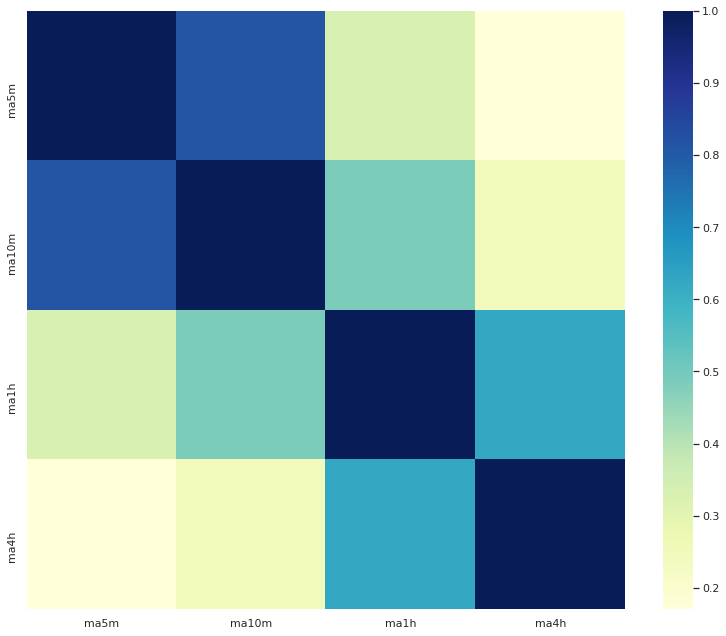

In [17]:
# Filter Method: Spearman's Cross Correlation > 0.95
# Make correlation matrix
corr_matrix = X_train.corr(method = "spearman").abs()

# Draw the heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
#plt.imshow()#"correlation_matrix.png", dpi = 1080)

In [18]:
# Select upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
X_train = X_train.drop(to_drop, axis = 1)
X_test = X_test.drop(to_drop, axis = 1)

## Recursive feature selection with model

In [19]:
# Create dict for classifiers with feature_importances_ attribute
FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}

### Tune a good model with best hyperparameter to begin with

In [20]:
#                        Tuning a classifier to use with RFECV                #
###############################################################################
# Define classifier to use as the base of the recursive feature elimination algorithm
selected_classifier = "Random Forest"
classifier = classifiers[selected_classifier]

# Tune classifier (Took = 4.8 minutes)
    
# Scale features via Z-score normalization
scaler = StandardScaler()

# Define steps in pipeline
steps = [("scaler", scaler), ("classifier", classifier)]

# Initialize Pipeline object
pipeline = Pipeline(steps = steps)
  
# Define parameter grid
param_grid = parameters[selected_classifier]

# Initialize GridSearch object
gscv = GridSearchCV(pipeline, param_grid, cv = 3,  n_jobs= -1, verbose = 1, scoring = "roc_auc")
                  
# Fit gscv
print(f"Now tuning {selected_classifier}. Go grab a beer or something.")
gscv.fit(X_train, np.ravel(y_train))  

# Get best parameters and score
best_params = gscv.best_params_
best_score = gscv.best_score_
        
# Update classifier parameters
tuned_params = {item[12:]: best_params[item] for item in best_params}
classifier.set_params(**tuned_params)

Now tuning Random Forest. Go grab a beer or something.
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.3min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=0.01,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

### Recursively select features with cross validation using that model

In [21]:
#                     Custom pipeline object to use with RFECV                #
###############################################################################
# Select Features using RFECV
class PipelineRFE(Pipeline):
    # Source: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [22]:
#      Feature Selection: Recursive Feature Selection with Cross Validation   #
###############################################################################
# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)

# Initialize RFECV object
feature_selector = RFECV(pipe, cv = 3, step = 1, scoring = "roc_auc", verbose = 1)

# Fit RFECV
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


### Display how feature set influence performance

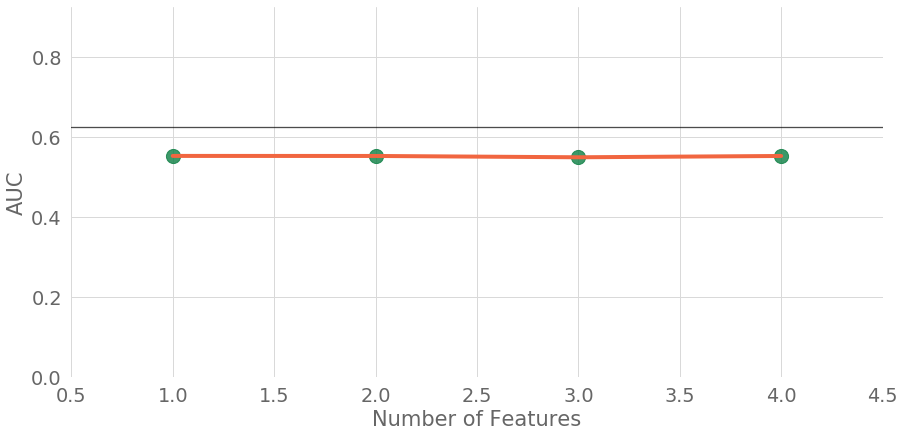

In [23]:
#                                 Performance Curve                           #
###############################################################################
# Get Performance Data
performance_curve = {"Number of Features": list(range(1, len(feature_names) + 1)),
                    "AUC": feature_selector.grid_scores_}
performance_curve = pd.DataFrame(performance_curve)

# Performance vs Number of Features
# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})
colors = sns.color_palette("RdYlGn", 20)
line_color = colors[3]
marker_colors = colors[-1]

# Plot
f, ax = plt.subplots(figsize=(13, 6.5))
sns.lineplot(x = "Number of Features", y = "AUC", data = performance_curve,
             color = line_color, lw = 4, ax = ax)
sns.regplot(x = performance_curve["Number of Features"], y = performance_curve["AUC"],
            color = marker_colors, fit_reg = False, scatter_kws = {"s": 200}, ax = ax)

# Axes limits
plt.xlim(0.5, len(feature_names)+0.5)
plt.ylim(0.0, 0.925)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0.625, color = 'black', linewidth = 1.3, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

### Recursively select a given number of features

In [24]:
#                    Feature Selection: Recursive Feature Selection           #
###############################################################################
# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)

# Initialize RFE object
feature_selector = RFE(pipe, n_features_to_select = 16, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features labels
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

### Display selected feature importances

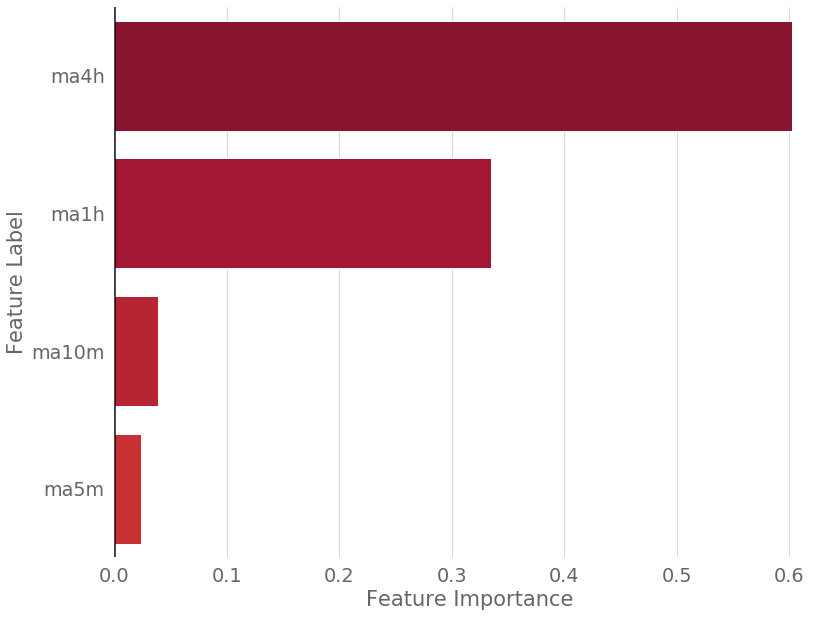

In [25]:
#                      Visualizing Selected Features Importance               #
###############################################################################
# Get selected features data set
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Train classifier
classifier.fit(X_train, np.ravel(y_train))

# Get feature importance
feature_importance = pd.DataFrame(selected_features, columns = ["Feature Label"])
feature_importance["Feature Importance"] = classifier.feature_importances_

# Sort by feature importance
feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False)

# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 9))
sns.barplot(x = "Feature Importance", y = "Feature Label",
            palette = reversed(sns.color_palette('YlOrRd', 15)),  data = feature_importance)

# Generate a bolded horizontal line at y = 0
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()


### Fit all classifiers with selected features

In [ ]:
#                           Classifier Tuning and Evaluation                  #
###############################################################################
# Initialize dictionary to store results
results = {}

# Tune and evaluate classifiers
for classifier_label, classifier in classifiers.items():
    # Print message to user
    print(f"Now tuning {classifier_label}.")
    
    # Scale features via Z-score normalization
    scaler = StandardScaler()
    
    # Define steps in pipeline
    steps = [("scaler", scaler), ("classifier", classifier)]
    
    # Initialize Pipeline object
    pipeline = Pipeline(steps = steps)
      
    # Define parameter grid
    param_grid = parameters[classifier_label]
    
    # Initialize GridSearch object
    gscv = GridSearchCV(pipeline, param_grid, cv = 3,  n_jobs= -1, verbose = 1, scoring = "roc_auc")
                      
    # Fit gscv
    gscv.fit(X_train, np.ravel(y_train))  
    
    # Get best parameters and score
    best_params = gscv.best_params_
    best_score = gscv.best_score_
    
    # Update classifier parameters and define new pipeline with tuned classifier
    tuned_params = {item[12:]: best_params[item] for item in best_params}
    classifier.set_params(**tuned_params)
            
    # Make predictions
    if classifier_label in DECISION_FUNCTIONS:
        y_pred = gscv.decision_function(X_test)
    else:
        y_pred = gscv.predict_proba(X_test)[:,1]
    
    # Evaluate model
    auc = metrics.roc_auc_score(y_test, y_pred)
    
    # Save results
    result = {"Classifier": gscv,
              "Best Parameters": best_params,
              "Training AUC": best_score,
              "Test AUC": auc}
    
    results.update({classifier_label: result})

Now tuning Random Forest.
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   40.3s


### Comparison between classifier

In [ ]:
#                                  Visualing Results                          #
###############################################################################
# Initialize auc_score dictionary
auc_scores = {
              "Classifier": [],
              "AUC": [],
              "AUC Type": []
              }

# Get AUC scores into dictionary
for classifier_label in results:
    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "AUC": [results[classifier_label]["Training AUC"]] + auc_scores["AUC"],
                       "AUC Type": ["Training"] + auc_scores["AUC Type"]})
    
    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "AUC": [results[classifier_label]["Test AUC"]] + auc_scores["AUC"],
                       "AUC Type": ["Test"] + auc_scores["AUC Type"]})

# Dictionary to PandasDataFrame
auc_scores = pd.DataFrame(auc_scores)

# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

    
# Colors
training_color = sns.color_palette("RdYlBu", 10)[1]
test_color = sns.color_palette("RdYlBu", 10)[-2]
colors = [training_color, test_color]

# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 9))

sns.barplot(x="AUC", y="Classifier", hue="AUC Type", palette = colors,
            data=auc_scores)

# Generate a bolded horizontal line at y = 0
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Simulate strategy

In [ ]:
# Convert to datafeed
from nextrade.data import Node, Module, DataFeed, Stream, Select

def preprocess(data: pd.DataFrame):
    features = []    
    features += [Stream(list(data.index)).rename("Timestamp")]
    for c in data.columns:
        s = Stream(list(data[c])).rename(data[c].name)
        features += [s]
        
    feed = DataFeed(features)
    feed.compile()
    return feed

## Select the best classifier in previous steps to be clf

In [ ]:
clf = results['QDA']['Classifier']

In [ ]:
y_train_proba = clf.predict_proba(X_train)
y_test_proba = clf.predict_proba(X_test)

In [ ]:
plt.hist(y_train_proba)

In [ ]:
plt.hist(y_test_proba)

In [ ]:
import pickle

with open('ml_results.pkl', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
with open('ml_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
results

# Test in Simulated Exchange

In [ ]:
train_start_time = pd.to_datetime('2020-01-01').date()
train_end_time = pd.to_datetime('2020-02-15').date()
test_start_time = pd.to_datetime('2020-07-15').date()
test_end_time = pd.to_datetime('2020-08-15').date()

train_data = data.loc[train_start_time:train_end_time]
test_data = data.loc[test_start_time:test_end_time]

In [ ]:
test_end_time = pd.to_datetime('2020-08-16').date()

In [ ]:
train_env_config = {'data':data, 
                    'start_time':train_start_time, 
                    'end_time':train_end_time, 
                    'preprocess':preprocess, 
                    'rl_env':False, 
                    'slice_len':-1,
                    'use_internal':True,
                    'exchange_name':'BITF',
                    'renders':['plotly']}
test_env_config = {'data':data, 
                    'start_time':test_start_time, 
                    'end_time':test_end_time, 
                    'preprocess':preprocess, 
                    'rl_env':False, 
                    'slice_len':-1,
                    'use_internal':True,
                    'exchange_name':'BITF',
                    'renders':['plotly']}

In [ ]:
from nextrade.environments import TradingEnvironment
train_env = TradingEnvironment(train_env_config)
test_env = TradingEnvironment(test_env_config)

In [ ]:
train_env.action_scheme.actions

### Define strategy

In [ ]:
def get_model_pred(clf, obs, feature_set):
    features = {x:obs[x] for x in feature_set}
    feature_df = pd.DataFrame(features,[0])
    pred = clf.predict(feature_df)[0]
    pred_proba = clf.predict_proba(feature_df)[0]
    return pred, pred_proba

In [ ]:
class Strategy():
    def __init__(self, clf, feature_set):
        self.clf = clf
        self.feature_set = feature_set
        
        self.position = 0
        self.last_price = -1
        self.price_threshold = 0.02
        
    def check_if_run_model(self, obs):
        self.position = obs['BITF:/BTC:/total']
        
        if_run = None
        if self.position > 0 and \
           np.abs(obs['close']/self.last_price-1) > self.price_threshold:
            if_run = False
        else:
            if_run = True
            
        return if_run
        
    def get_action(self, obs):
        pred, pred_proba = get_model_pred(self.clf, obs, self.feature_set)
        if pred_proba[1]>0.6:
            action = 3
            self.last_price = obs['close']
        else:
            action = 4
            self.last_price = obs['close']
        return action

### Run strategy on simulated exchange

In [ ]:
import time
env = test_env

start = time.time()
strategy = Strategy(clf, selected_features)
obs = env.reset()

strat_time_list = []
env_time_list = []

done = False
while not done:
#for i in range(1000):
    start = time.time()
    if_run = strategy.check_if_run_model(obs)
    if if_run:
        action = strategy.get_action(obs)
    else:
        action = 0
    end = time.time()
    strat_time_list.append(end-start)
    
    start = time.time()
    obs, reward, done, info = env.step(action)
    end = time.time()
    env_time_list.append(end-start)
print("Strat time: {:.2f} s Env time: {:.2f} s".format(np.sum(strat_time_list), np.sum(env_time_list)))
print("Return rate: {:.2f}%".format(100*obs['curr_return']))

In [ ]:
metrics = ['net_worth','BITF:/USD-BTC','BITF:/BTC:/worth']
env.portfolio.performance[metrics].plot()

# Test in Simulated Swap Exchange (NOT implemented)

In [ ]:
train_env_config = {'data':data, 
                    'start_time':train_start_time, 
                    'end_time':train_end_time, 
                    'preprocess':preprocess, 
                    'rl_env':False, 
                    'slice_len':-1,
                    'use_internal':True,
                    'exchange_name':'BITF',
                    'renders':['plotly']}

In [ ]:
from nextrade.environments import TradingEnvironment

In [ ]:
import nextrade.rewards as rewards

In [ ]:
from nextrade.environments import SwapTradingEnvironment
env = TradingEnvironment(train_env_config)

In [ ]:
feed = preprocess(data)

In [ ]:
env.action_scheme.actions

In [ ]:
import time
start = time.time()
obs = env.reset()
for i in range(1000):
    action = 0
    if obs['ma5m'] > obs['ma10m']:
        action = 3
    else:
        action = 4
    obs, reward, done, info = env.step(action)
    #print('Step {} action {}'.format(info['step'], action, obs['curr_return']))

    end = time.time()
print(end - start)

In [ ]:
obs

price_history = pd.concat([
    cdd.fetch("Coinbase", "USD", "BTC", "1h"),
], axis=1)
price_history = price_history.rename({"date": "datetime"}, axis=1)

train_price_history = price_history[price_history['datetime'].between(train_start_time, train_end_time, inclusive=True)]
train_price_history.reset_index(drop=True, inplace=True)
test_price_history = price_history[price_history['datetime'].between(test_start_time, test_end_time, inclusive=True)]
test_price_history.reset_index(drop=True, inplace=True)

## Setup Trading Environment

# Run training through Ray.Tune

In [ ]:
import ray
from ray import tune
from ray.tune.registry import register_env
from wandb.ray import WandbLogger

In [ ]:
from typing import Dict

from ray.rllib.env import BaseEnv
from ray.rllib.policy import Policy
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.evaluation import MultiAgentEpisode, RolloutWorker
from ray.rllib.agents.callbacks import DefaultCallbacks


class MyCallbacks(DefaultCallbacks):
    def on_episode_start(self, worker: RolloutWorker, base_env: BaseEnv,
                         policies: Dict[str, Policy],
                         episode: MultiAgentEpisode, **kwargs):
        pass

    def on_episode_step(self, worker: RolloutWorker, base_env: BaseEnv,
                        episode: MultiAgentEpisode, **kwargs):
        pass

    def on_episode_end(self, worker: RolloutWorker, base_env: BaseEnv,
                       policies: Dict[str, Policy], episode: MultiAgentEpisode,
                       **kwargs):
        print("episode {} ended with return {}".format(
            episode.episode_id, episode.last_observation_for()[-1][-3]))
        
        episode.custom_metrics["return_rate"] = episode.last_observation_for()[-1][-3]
        episode.custom_metrics["yearly_return_rate"] = episode.last_observation_for()[-1][-2]
        

    def on_sample_end(self, worker: RolloutWorker, samples: SampleBatch,
                      **kwargs):
        pass

    def on_train_result(self, trainer, result: dict, **kwargs):
        pass
        #print("trainer.train() result: {} -> {} episodes".format(
        #    trainer, result["episodes_this_iter"]))
        # you can mutate the result dict to add new fields to return
        result["callback_ok"] = True

    def on_postprocess_trajectory(
            self, worker: RolloutWorker, episode: MultiAgentEpisode,
            agent_id: str, policy_id: str, policies: Dict[str, Policy],
            postprocessed_batch: SampleBatch,
            original_batches: Dict[str, SampleBatch], **kwargs):
        pass
        #print("postprocessed {} steps".format(postprocessed_batch.count))
        if "num_batches" not in episode.custom_metrics:
            episode.custom_metrics["num_batches"] = 0
        episode.custom_metrics["num_batches"] += 1

In [ ]:
from ray.rllib.evaluation.metrics import collect_episodes, summarize_episodes
def eval_fn(trainer, eval_workers):
    """Example of a custom evaluation function.
    Arguments:
        trainer (Trainer): trainer class to evaluate.
        eval_workers (WorkerSet): evaluation workers.
    Returns:
        metrics (dict): evaluation metrics dict.
    """
    print("de")
    # We configured 2 eval workers in the training config.
    worker_1, worker_2 = eval_workers.remote_workers()

    # Set different env settings for each worker. Here we use a fixed config,
    # which also could have been computed in each worker by looking at
    # env_config.worker_index (printed in SimpleCorridor class above).
    #worker_1.foreach_env.remote(lambda env: env.set_corridor_length(4))
    #worker_2.foreach_env.remote(lambda env: env.set_corridor_length(7))

    for i in range(5):
        print("Custom evaluation round", i)
        # Calling .sample() runs exactly one episode per worker due to how the
        # eval workers are configured.
        ray.get([w.sample.remote() for w in eval_workers.remote_workers()])

    # Collect the accumulated episodes on the workers, and then summarize the
    # episode stats into a metrics dict.
    episodes, _ = collect_episodes(
        remote_workers=eval_workers.remote_workers(), timeout_seconds=99999)
    # You can compute metrics from the episodes manually, or use the
    # convenient `summarize_episodes()` utility:
    metrics = summarize_episodes(episodes)
    # Note that the above two statements are the equivalent of:
    # metrics = collect_metrics(eval_workers.local_worker(),
    #                           eval_workers.remote_workers())
    print(metrics)
    # You can also put custom values in the metrics dict.
    metrics["foo"] = 1
    return metrics

In [ ]:
from ray.rllib.agents.dqn import ApexTrainer
from ray.rllib.agents import dqn
from ray.tune.registry import register_env

from nextrade.environments import TradingEnvironment

register_env("Trade", lambda config: TradingEnvironment(config))

config = dqn.apex.APEX_DEFAULT_CONFIG.copy()

config["env"] = "Trade"
config["env_config"] = train_env_config
config["monitor"] = True
config["env_config"]["wandb"] = {"project": "test", "monitor_gym": True}
config["log_level"] = "ERROR"
config["timesteps_per_iteration"] = 1440 * 4 * 1 
config["target_network_update_freq"] = 1000
config["learning_starts"] = 50000
config["num_workers"] = 4
config["num_envs_per_worker"] = 1
config["callbacks"] = MyCallbacks
    
config["evaluation_num_workers"] = 2 
config["custom_eval_function"] = eval_fn
config["evaluation_interval"] = 1
config["evaluation_num_episodes"] = 1
config["evaluation_config"] = {
            "env": "Trade",
            "env_config": test_env_config
        }

ray.init(num_cpus=32)
tune.run(ApexTrainer,
            loggers=[],
            config=config,
         )

In [ ]:
ray.shutdown()

In [ ]:
len(env.feed.inputs[0]._array)

In [ ]:
data.index

In [ ]:
len(env.net_worth)

In [ ]:
for i in range(100):
    env.step(1)[0]

In [ ]:
print(env.step(1))

In [ ]:
for i in range(100):
    print(env.step(1)[0])

In [ ]:
env.reward_scheme.get_reward(env._portfolio)

In [ ]:
env._portfolio.performance['net_worth']

In [ ]:
env.reward_scheme.window_size

In [ ]:
for wallet in env.portfolio._wallets:
    print(env.portfolio._wallets[wallet])

In [ ]:
env.feed.inputs[0].__dict__

In [ ]:
env.reset();
for node in env.feed.inputs:
    if isinstance(node, Stream):
        print(len(node._array))
        print(node._cursor)
        node._cursor = 2
        print(node._cursor)

In [ ]:
env.portfolio._wallets[('ab499fcc-f5e9-49b6-9f61-7bc44ae64d34', 'USD')]._exchange.inputs[0]._cursor
env.feed.inputs[0]._cursor

In [ ]:
len(env.feed._array)

In [ ]:
for i in range(10):
    env.feed.next()    
    print("")
    print("obs: {}".format(env.feed.value))
    #print("ex: {}".format(env.portfolio._wallets[('ab499fcc-f5e9-49b6-9f61-7bc44ae64d34', 'USD')]._exchange._prices['USD/BTC'].value))

In [ ]:
import time

start = time.time()

for i in range(1000):
    env.step(0)

end = time.time()
print(end - start)

start = time.time()
for i in range(1000):
    env.feed.next()   

end = time.time()
print(end - start)

In [ ]:
for i in range(100):
    env.feed.next()    
    print("obs: {}".format(env.feed.value['BITFINEX_BTC:close']))
    print("ex: {}".format(env.portfolio._wallets[('ab499fcc-f5e9-49b6-9f61-7bc44ae64d34', 'USD')]._exchange._prices['USD/BTC'].value))

In [ ]:
env.action_scheme.action_space
orders = env.action_scheme.get_order(1, env.portfolio)

In [ ]:
orders

In [ ]:
env.feed.next()

In [ ]:
env.exchanges._prices

In [ ]:
for i in range(100):
    print(env.action_scheme.exchange_pairs[0].price)

In [ ]:
import time

start = time.time()

for i in range(1000):
    env.step(0)

end = time.time()
print(end - start)

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

In [ ]:
train_return_rate_list = []
test_return_rate_list = []

def test_strat(trainer, step, total_step):
    train_env = TradingEnvironment(train_env_config)
    obs = train_env.reset()
    done = False

    while done == False:
        a = trainer.compute_action(obs)
        obs, reward, done, info = train_env.step(action=a)

    train_return_rate = train_env.portfolio.performance.net_worth.iloc[-1]/train_env.portfolio.performance.net_worth.iloc[0]
    train_return_rate = pow(train_return_rate, 525600/len(train_data))-1
    
    test_env = TradingEnvironment(test_env_config)
    obs = test_env.reset()
    done = False

    while done == False:
        a = trainer.compute_action(obs)
        obs, reward, done, info = test_env.step(action=a)
        
    test_return_rate = test_env.portfolio.performance.net_worth.iloc[-1]/test_env.portfolio.performance.net_worth.iloc[0]
    test_return_rate = pow(test_return_rate, 525600/len(test_data))-1



    train_return_rate_list.append(train_return_rate)
    test_return_rate_list.append(test_return_rate)
    
    print("Episode {} has train return {} and test return {}".format(step, train_return_rate, test_return_rate))
    ax.clear()
    ax.plot(train_return_rate_list,label='train')
    ax.plot(test_return_rate_list,label='test')
    fig.canvas.draw()
    
    #test_env.portfolio.performance.net_worth.plot()
    #test_env.render(episode=step)

## Example Data Feed Observation

Even though this observation contains data from the internal data feed, since `use_internal=False` this data will not be provided as input to the observation history. The data that will be added to observation history of the environment will strictly be the nodes that have been included into the data feed that has been provided as a parameter to the trading environment.

## Setup and Train DQN Agent

In [ ]:
from nextrade.agents import DQNAgent
#agent = DQNAgent(train_env_config = env_config,\
#                 test_env_config = env_config)

In [ ]:
import argparse
import ray
from ray import tune
from ray.tune.registry import register_env
from ray.rllib.examples.env.repeat_after_me_env import RepeatAfterMeEnv
from ray.rllib.examples.env.repeat_initial_obs_env import RepeatInitialObsEnv
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.test_utils import check_learning_achieved

In [ ]:
from ray.rllib.agents.trainer import with_common_config
from ray.rllib.utils import merge_dicts
from ray.rllib.utils.deprecation import deprecation_warning, DEPRECATED_VALUE
from ray.rllib.agents.dqn.dqn import DQNTrainer, \
    DEFAULT_CONFIG as DQN_CONFIG, calculate_rr_weights
from ray.rllib.agents.dqn.apex import ApexTrainer, APEX_DEFAULT_CONFIG


APEX_DEFAULT_CONFIG = merge_dicts(
    DQN_CONFIG,  # see also the options in dqn.py, which are also supported
    {
        "optimizer": merge_dicts(
            DQN_CONFIG["optimizer"], {
                "max_weight_sync_delay": 400,
                "num_replay_buffer_shards": 4,
                "debug": False
            }),
        "n_step": 3,
        "num_gpus": 1,
        "num_workers": 32,
        "buffer_size": 2000000,
        "learning_starts": 50000,
        "train_batch_size": 512,
        "rollout_fragment_length": 50,
        "target_network_update_freq": 500000,
        "timesteps_per_iteration": 25000,
        "exploration_config": {"type": "PerWorkerEpsilonGreedy"},
        "worker_side_prioritization": True,
        "min_iter_time_s": 30,
        # If set, this will fix the ratio of replayed from a buffer and learned
        # on timesteps to sampled from an environment and stored in the replay
        # buffer timesteps. Otherwise, replay will proceed as fast as possible.
        "training_intensity": None,
    },
)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import ray.rllib.agents.dqn as dqn

data_length = len(data)

parser = argparse.ArgumentParser()
parser.add_argument("--num-cpus", type=int, default=10)

args = parser.parse_known_args()[0]

try:
    ray.shutdown()
    ray.init(num_cpus=args.num_cpus+1 or None)
except:
    ray.init(num_cpus=args.num_cpus+1 or None)

register_env("Trade", lambda config: TradingEnvironment(train_env_config))

config = APEX_DEFAULT_CONFIG

config['num_workers'] = args.num_cpus
#config['num_envs_per_worker'] = 5
#config['sample_batch_size'] = data_length
#config['train_batch_size'] = data_length
#config['num_gpus'] = 1
#config['timesteps_per_iteration'] = 0
#config['framework'] = 'torch'

trainer = dqn.ApexTrainer(env="Trade", config=config)
#results = tune.run(trainer, config=config, stop=stop, verbose=1)

total_step = 100000

for step in range(0,total_step):
    results = trainer.train()
    if step % 1 == 0:
        test_strat(trainer, step, total_step)